# Imports and Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image 
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Dropout, Conv1D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


>Creating list of images and labels (each folder in the dataset is taken as a class)



In [ ]:
SIZE = 224
def getdata(base):
    x=[]
    y=[]
    c=0
    class_names = []
    combined = []
    for folder in os.listdir(base):
        class_names.append(folder)
        for pic in os.listdir(base+"/"+folder):
            img=Image.open(base+"/"+folder+"/"+pic)
            img=img.resize((SIZE,SIZE))
            combined.append([folder,np.array(img)])
    combined.sort(key = lambda x: x[0])
    class_names.sort()
    for i in combined:
        x.append(i[1])
    for i in range(len(x)-1):
        if combined[i][0]!=combined[i+1][0]:
            y.append(c)
            c+=1
        else:
            y.append(c)
    y.append(c)
    x=np.array(x)
    y=np.array(y)
    return (x,y,class_names)

In [ ]:
(X,Y,class_names) = getdata("/content/drive/MyDrive/dataset")
print("shape of image list from dataset =",X.shape) 
print("shape of class labels list from dataset =",Y.shape)

shape of image list from dataset = (88, 224, 224, 3)
shape of class list from dataset = (88,)


In [ ]:
(x_test,y_test,class_names_test) = getdata("/content/drive/MyDrive/dataset_test")
print("shape of image list from test dataset =",x_test.shape) 
print("shape of class labels list from test dataset =",y_test.shape)

shape of image list from test dataset = (40, 224, 224, 3)
shape of class list from test dataset = (40,)


> Making pairs of images along with label to feed into Siamese network

In [ ]:
def make_pairs(x, y, base):
    num_classes = len(os.listdir(base))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    pairs = []
    labels = []
    for idx1 in range(len(x*2)):
      
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]    
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

In [ ]:
pairs_x,pairs_y=make_pairs(X,Y,"/content/drive/MyDrive/dataset")
print("shape of image pairs array is",pairs_x.shape)
print("shape of labels array is",pairs_y.shape)

shape of image pairs array is (176, 2, 224, 224, 3)
shape of labels array is (176,)


In [ ]:
pairs_test_x,pairs_test_y=make_pairs(x_test,y_test,"/content/drive/MyDrive/dataset_test")
print("shape of test image pairs array is",pairs_test_x.shape)
print("shape of test labels array is",pairs_test_y.shape)

shape of test image pairs array is (80, 2, 224, 224, 3)
shape of test labels array is (80,)


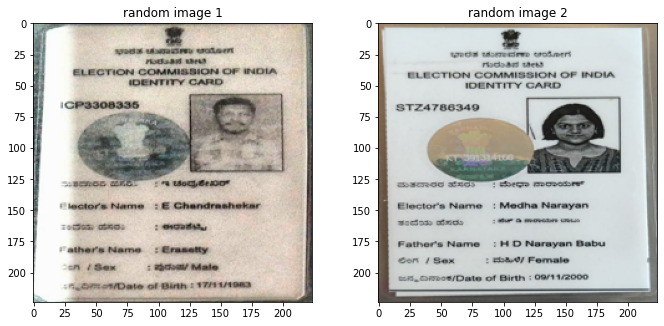

label for this pair is 1


In [ ]:
rand = random.randrange(0, pairs_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_x[rand][0])
ax[0].set(title='random image 1')
ax[1].imshow(pairs_x[rand][1])
ax[1].set(title='random image 2')
plt.show()
print("label for this pair is",pairs_y[rand])

> Splitting the dataset into training and testing sets



In [ ]:
pairs_train_x, pairs_val_x, pairs_train_y, pairs_val_y = train_test_split(pairs_x,pairs_y, test_size=0.20, random_state=5,stratify=pairs_y)

In [ ]:
print("training set shape:",pairs_train_x.shape)
print("training set labels shape:",pairs_train_y.shape)
print("validation set shape:",pairs_val_x.shape)
print("validation set labels shape:",pairs_val_y.shape)

training set shape: (140, 2, 224, 224, 3)
training set labels shape: (140,)
validation set shape: (36, 2, 224, 224, 3)
validation set labels shape: (36,)


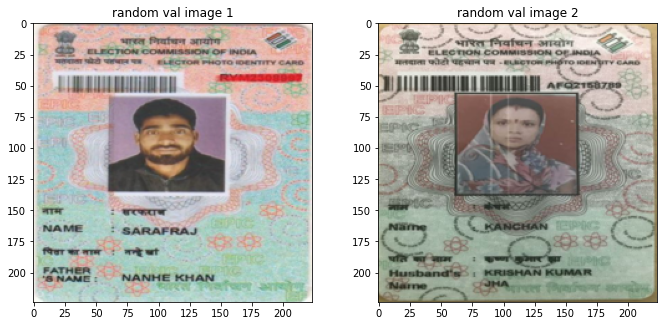

label for this validation pair is 1


In [ ]:
rand = random.randrange(0, pairs_val_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_val_x[rand][0])
ax[0].set(title='random val image 1')
ax[1].imshow(pairs_val_x[rand][1])
ax[1].set(title='random val image 2')
plt.show()
print("label for this validation pair is",pairs_val_y[rand])

> **Cosine Similarity between Embeddings(vectors)**

In [ ]:
def cosine_similarity(vects):
  x, y = vects
  dotxy = Dot(axes=1)([x, y])
  magx  = K.sqrt(Dot(axes=1)([x,x]))
  magy  = K.sqrt(Dot(axes=1)([y,y]))
  return (dotxy/(magx*magy))

# Initial trial Model

In [ ]:
input = Input((SIZE,SIZE,3))
x = Flatten()(input)
x = Dense(28, activation='relu')(x)
x = Dense(52, activation='relu')(x)
dense = Model(input, x)


input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))

dense1 = dense(input1)
dense2 = dense(input2)

output_layer = Lambda(cosine_similarity)([dense1,dense2])
model = Model(inputs=[input1, input2], outputs=output_layer)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 52)           4216320     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_val_x[:,0]
d=pairs_val_x[:,1]
history=model.fit([a,b], pairs_train_y,batch_size=35, epochs= 20, validation_data=([c,d], pairs_val_y))

Epoch 1/20
4/4 [==============================] - 4s 191ms/step - loss: 2.5684 - accuracy: 0.4886 - val_loss: 2.9233 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 0s 36ms/step - loss: 2.9446 - accuracy: 0.4724 - val_loss: 2.5415 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 0s 39ms/step - loss: 2.2809 - accuracy: 0.5124 - val_loss: 2.2868 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 0s 38ms/step - loss: 2.2274 - accuracy: 0.4752 - val_loss: 2.0505 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 0s 36ms/step - loss: 1.6403 - accuracy: 0.5410 - val_loss: 1.8390 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 0s 36ms/step - loss: 1.8845 - accuracy: 0.4305 - val_loss: 1.6390 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 0s 36ms/step - loss: 1.5344 - accuracy: 0.4600 - val_loss: 1.4568 - val_accuracy: 0.5000
Epoch 8/20
4/4 [==========

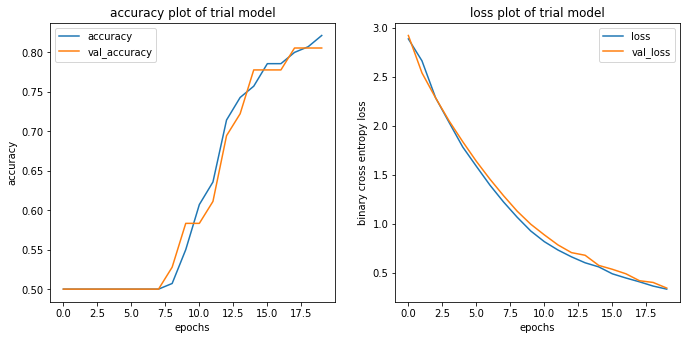

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of trial model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of trial model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

accuracy of initial model model is 0.85


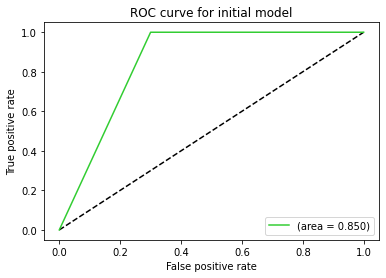

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=model.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of initial model model is",accuracy_score(y_hat,y))

fpr, tpr, thresholds = roc_curve(y, y_hat)
auc = roc_auc_score(y, y_hat)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc), color="limegreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for initial model')
plt.legend(loc='best')
plt.show()

# VGG16 based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = VGG16(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='sigmoid')(x)
# x = Dense(256, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
vgg_model = Model(inputs=base_model.input, outputs=x)

vgg_encoded1 = vgg_model(input1)
vgg_encoded2 = vgg_model(input2)
    
output_layer = Lambda(cosine_similarity)([vgg_encoded1,vgg_encoded2])
siamese_net_1 = Model(inputs=[input1,input2],outputs=output_layer)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
siamese_net_1.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 512)          15764800    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[0][0]              

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_val_x[:,0]
d=pairs_val_x[:,1]
history=siamese_net_1.fit([a,b], pairs_train_y,batch_size=35, epochs= 25, validation_data=([c,d], pairs_val_y))

Epoch 1/25
4/4 [==============================] - 46s 2s/step - loss: 1.0305 - accuracy: 0.4981 - val_loss: 0.5008 - val_accuracy: 0.7222
Epoch 2/25
4/4 [==============================] - 3s 915ms/step - loss: 0.3744 - accuracy: 0.8705 - val_loss: 0.2880 - val_accuracy: 0.9167
Epoch 3/25
4/4 [==============================] - 3s 914ms/step - loss: 0.1869 - accuracy: 0.9705 - val_loss: 0.1889 - val_accuracy: 0.9722
Epoch 4/25
4/4 [==============================] - 3s 916ms/step - loss: 0.0846 - accuracy: 0.9876 - val_loss: 0.1426 - val_accuracy: 0.9722
Epoch 5/25
4/4 [==============================] - 3s 920ms/step - loss: 0.0588 - accuracy: 1.0000 - val_loss: 0.1194 - val_accuracy: 0.9722
Epoch 6/25
4/4 [==============================] - 3s 916ms/step - loss: 0.0372 - accuracy: 1.0000 - val_loss: 0.0955 - val_accuracy: 0.9722
Epoch 7/25
4/4 [==============================] - 3s 921ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.9722
Epoch 8/25
4/4 [======

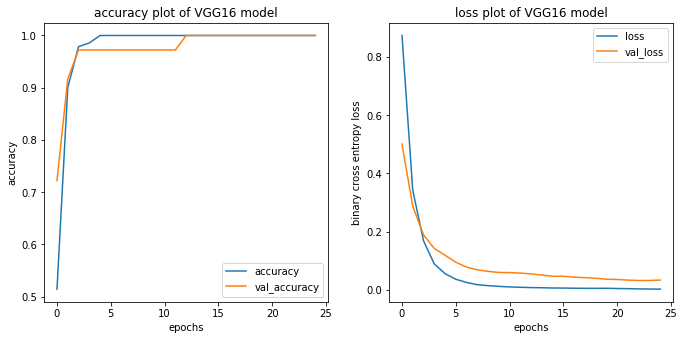

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of VGG16 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of VGG16 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

> Testing the VGG model

accuracy of VGG16 model is 1.0


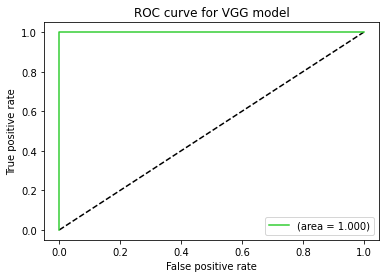

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_1.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of VGG16 model is",accuracy_score(y_hat,y))

fpr_vgg, tpr_vgg, thresholds = roc_curve(y, y_hat)
auc_vgg = roc_auc_score(y, y_hat)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='(area = {:.3f})'.format(auc_vgg), color="limegreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for VGG model')
plt.legend(loc='best')
plt.show()

# ResNet50 based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = ResNet50(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
resnet_model = Model(inputs=base_model.input, outputs=x)

resnet_encoded1 = resnet_model(input1)
resnet_encoded2 = resnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([resnet_encoded1,resnet_encoded2])
siamese_net_2 = Model(inputs=[input1,input2],outputs=output_layer)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
siamese_net_2.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 512)          26210688    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_4[0][0]              

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_val_x[:,0]
d=pairs_val_x[:,1]
history=siamese_net_2.fit([a,b], pairs_train_y,batch_size=35, epochs= 25, validation_data=([c,d], pairs_val_y))

Epoch 1/25
4/4 [==============================] - 15s 2s/step - loss: 2.4390 - accuracy: 0.5124 - val_loss: 1.4761 - val_accuracy: 0.5000
Epoch 2/25
4/4 [==============================] - 3s 720ms/step - loss: 1.1513 - accuracy: 0.4886 - val_loss: 0.9614 - val_accuracy: 0.5278
Epoch 3/25
4/4 [==============================] - 3s 721ms/step - loss: 0.6785 - accuracy: 0.5381 - val_loss: 0.7568 - val_accuracy: 0.7222
Epoch 4/25
4/4 [==============================] - 3s 725ms/step - loss: 0.4261 - accuracy: 0.7705 - val_loss: 0.6394 - val_accuracy: 0.7500
Epoch 5/25
4/4 [==============================] - 3s 723ms/step - loss: 0.3109 - accuracy: 0.8695 - val_loss: 0.5559 - val_accuracy: 0.7778
Epoch 6/25
4/4 [==============================] - 3s 721ms/step - loss: 0.2258 - accuracy: 0.9638 - val_loss: 0.4681 - val_accuracy: 0.8611
Epoch 7/25
4/4 [==============================] - 3s 725ms/step - loss: 0.1710 - accuracy: 0.9505 - val_loss: 0.3833 - val_accuracy: 0.9167
Epoch 8/25
4/4 [======

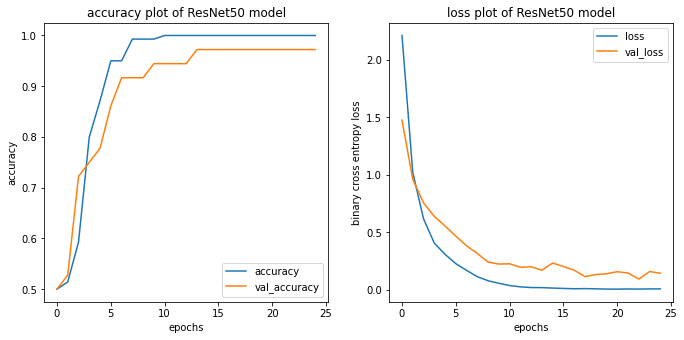

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of ResNet50 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of ResNet50 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

> Testing the ResNet model

accuracy of ResNet50 model is 1.0


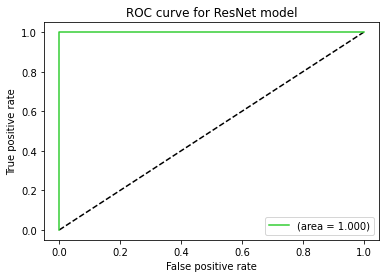

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_2.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of ResNet50 model is",accuracy_score(y_hat,y))

fpr_res, tpr_res, thresholds = roc_curve(y, y_hat)
auc_res = roc_auc_score(y, y_hat)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res, tpr_res, label='(area = {:.3f})'.format(auc_res), color="limegreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ResNet model')
plt.legend(loc='best')
plt.show()

# EfficientNet based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = tf.keras.applications.EfficientNetB4(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
efficientnet_model = Model(inputs=base_model.input, outputs=x)

encoded1 = efficientnet_model(input1)
encoded2 = efficientnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([encoded1,encoded2])
siamese_net_3 = Model(inputs=[input1,input2],outputs=output_layer)

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
siamese_net_3.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 512)          20034655    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           model_6[0][0]              

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_val_x[:,0]
d=pairs_val_x[:,1]
history=siamese_net_3.fit([a,b], pairs_train_y,batch_size=35, epochs= 25, validation_data=([c,d], pairs_val_y))

Epoch 1/30
4/4 [==============================] - 37s 3s/step - loss: 3.2780 - accuracy: 0.5143 - val_loss: 2.0978 - val_accuracy: 0.5000
Epoch 2/30
4/4 [==============================] - 4s 952ms/step - loss: 1.8385 - accuracy: 0.4857 - val_loss: 1.1839 - val_accuracy: 0.5000
Epoch 3/30
4/4 [==============================] - 4s 954ms/step - loss: 1.0202 - accuracy: 0.5029 - val_loss: 0.7534 - val_accuracy: 0.5833
Epoch 4/30
4/4 [==============================] - 4s 957ms/step - loss: 0.5913 - accuracy: 0.6457 - val_loss: 0.5459 - val_accuracy: 0.7222
Epoch 5/30
4/4 [==============================] - 4s 955ms/step - loss: 0.4489 - accuracy: 0.7467 - val_loss: 0.4352 - val_accuracy: 0.7778
Epoch 6/30
4/4 [==============================] - 4s 958ms/step - loss: 0.3113 - accuracy: 0.8943 - val_loss: 0.3525 - val_accuracy: 0.8056
Epoch 7/30
4/4 [==============================] - 4s 953ms/step - loss: 0.2719 - accuracy: 0.8924 - val_loss: 0.2283 - val_accuracy: 0.8889
Epoch 8/30
4/4 [======

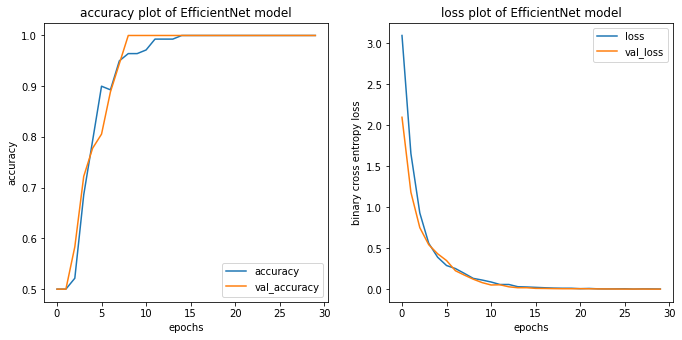

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of EfficientNet model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of EfficientNet model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

> Testing the EfficientNet model

accuracy of EfficientNet model is 1.0


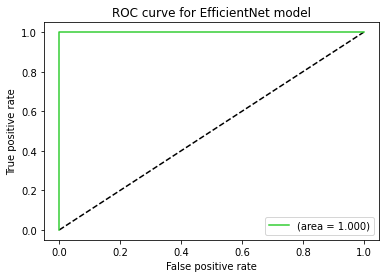

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_3.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of EfficientNet model is",accuracy_score(y_hat,y))

fpr_eff, tpr_eff, thresholds = roc_curve(y, y_hat)
auc_eff = roc_auc_score(y, y_hat)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_eff, tpr_eff, label='(area = {:.3f})'.format(auc_eff), color="limegreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for EfficientNet model')
plt.legend(loc='best')
plt.show()

# Test Predictions
---
Random pairs are chosen from the test set and the predictions for this test from all the 3 models is given

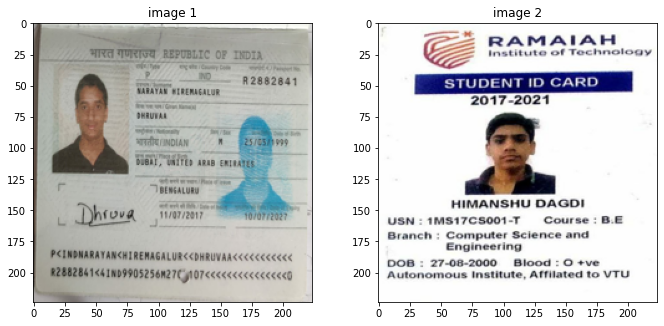

true label for the above pair: 0
prediction from VGG16 model: 0.0049389633
prediction from ResNet50 model: 0.018269733
prediction from EfficientNetB3 model: 0.00408575


In [ ]:
rand = random.randrange(0, pairs_test_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_test_x[rand][0])
ax[0].set(title='image 1')
ax[1].imshow(pairs_test_x[rand][1])
ax[1].set(title='image 2')
plt.show()

#predictions
print("true label for the above pair:",pairs_test_y[rand])
print("prediction from VGG16 model:",siamese_net_1.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from ResNet50 model:",siamese_net_2.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from EfficientNetB3 model:",siamese_net_3.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])

> **ROC curves**

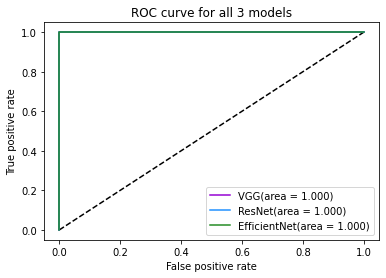

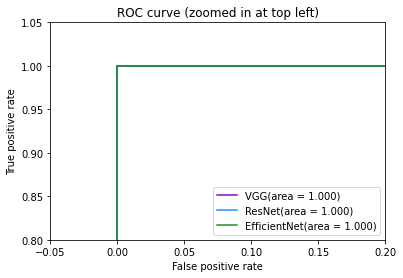

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG(area = {:.3f})'.format(auc_vgg), color="darkviolet")
plt.plot(fpr_res, tpr_res, label='ResNet(area = {:.3f})'.format(auc_res), color="dodgerblue")
plt.plot(fpr_eff, tpr_eff, label='EfficientNet(area = {:.3f})'.format(auc_eff), color="forestgreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for all 3 models')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(-0.05, 0.2)
plt.ylim(0.8, 1.05)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG(area = {:.3f})'.format(auc_vgg), color="darkviolet")
plt.plot(fpr_res, tpr_res, label='ResNet(area = {:.3f})'.format(auc_res), color="dodgerblue")
plt.plot(fpr_eff, tpr_eff, label='EfficientNet(area = {:.3f})'.format(auc_eff), color="forestgreen")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Embedings from the models
---
We pass all images through the 3 models to get the individual embeddings

In [ ]:
#embedding shapes
print("embedding of random image from VGG model:",vgg_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape)
print("embedding of random image from resnet model:",resnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape)
print("embedding of random image from efficientnet model:",efficientnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape)

embedding of random image from VGG model: (1, 512)
embedding of random image from resnet model: (1, 512)
embedding of random image from efficientnet model: (1, 512)


In [ ]:
vgg_test_embeddings = []
resnet_test_embeddings = []
efficientnet_test_embeddings = []
for i in x_test:
  efficientnet_test_embeddings.append(efficientnet_model.predict([np.expand_dims(i,axis=0)]))
  resnet_test_embeddings.append(resnet_model.predict([np.expand_dims(i,axis=0)]))
  vgg_test_embeddings.append(vgg_model.predict([np.expand_dims(i,axis=0)]))

In [ ]:
print("no. of embeddings:",len(efficientnet_test_embeddings),len(resnet_test_embeddings),len(vgg_test_embeddings))

no. of embeddings: 40 40 40


In [ ]:
vgg_train_embeddings = []
resnet_train_embeddings = []
efficientnet_train_embeddings = []
for i in X:
  efficientnet_train_embeddings.append(efficientnet_model.predict([np.expand_dims(i,axis=0)]))
  resnet_train_embeddings.append(resnet_model.predict([np.expand_dims(i,axis=0)]))
  vgg_train_embeddings.append(vgg_model.predict([np.expand_dims(i,axis=0)]))

In [ ]:
print("no. of embeddings:",len(efficientnet_train_embeddings),len(resnet_train_embeddings),len(vgg_train_embeddings))

no. of embeddings: 88 88 88


# Cosine Similarity Matrices
---
Here we are plotting cosine similarity matrices for the cosine similarities of embeddings from each model

* Ideally, items should have high intra class cosine similarity and low inter class cosine similarity

* The representation for the ideal cosine similarity is given at the bottom

In [ ]:
efficientnet_matrix = []
for i in range(len(efficientnet_test_embeddings)):
  m = []
  for j in range(len(efficientnet_test_embeddings)):
    m.append(cosine_similarity([tf.constant(efficientnet_test_embeddings[i]),tf.constant(efficientnet_test_embeddings[j])]).numpy()[0][0])
  efficientnet_matrix.append(m)

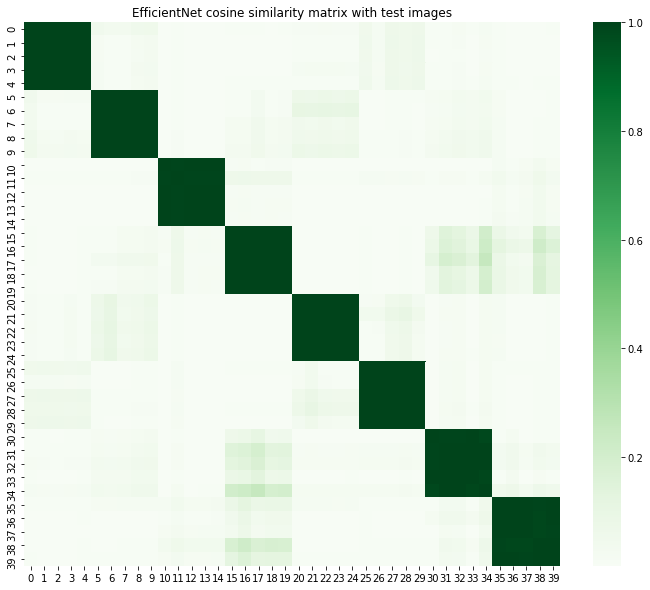

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='EfficientNet cosine similarity matrix with test images')
ax = sns.heatmap(np.array(efficientnet_matrix),cmap="Greens")

In [ ]:
resnet_matrix = []
for i in range(len(resnet_test_embeddings)):
  m = []
  for j in range(len(resnet_test_embeddings)):
    m.append(cosine_similarity([tf.constant(resnet_test_embeddings[i]),tf.constant(resnet_test_embeddings[j])]).numpy()[0][0])
  resnet_matrix.append(m)

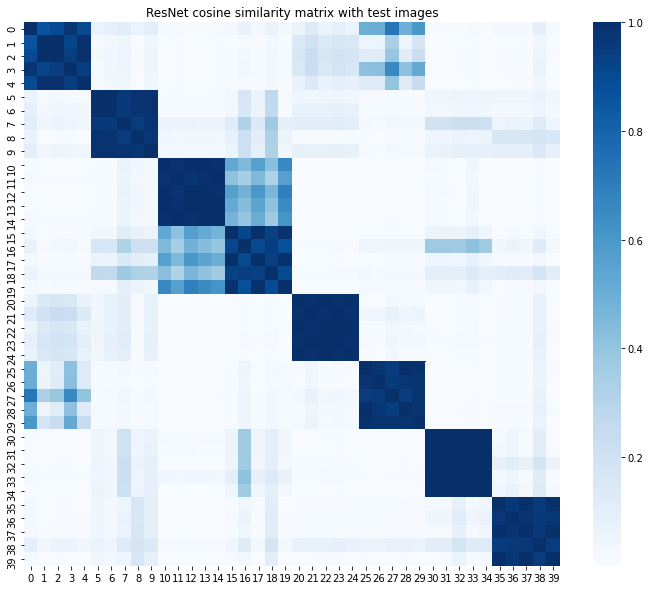

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ResNet cosine similarity matrix with test images')
ax = sns.heatmap(np.array(resnet_matrix),cmap="Blues")

In [ ]:
vgg_matrix = []
for i in range(len(vgg_test_embeddings)):
  m = []
  for j in range(len(vgg_test_embeddings)):
    m.append(cosine_similarity([tf.constant(vgg_test_embeddings[i]),tf.constant(vgg_test_embeddings[j])]).numpy()[0][0])
  vgg_matrix.append(m)

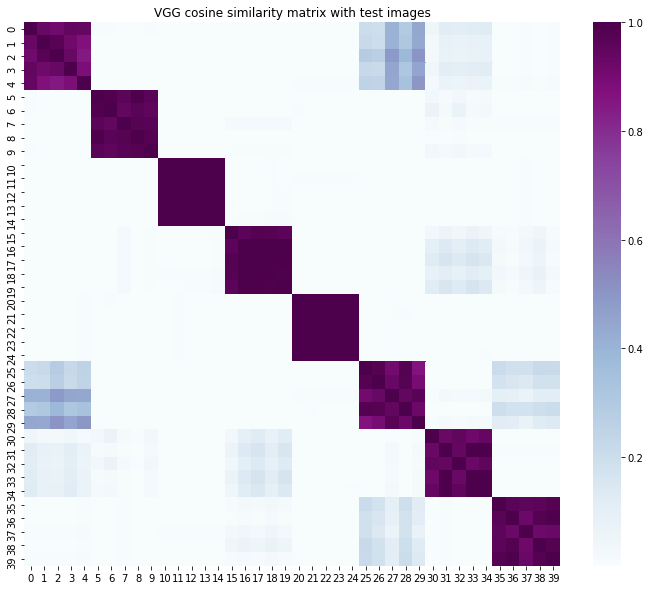

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='VGG cosine similarity matrix with test images')
ax = sns.heatmap(np.array(vgg_matrix),cmap="BuPu")

In [ ]:
#Getting the ideal values of the matrix

ideal_mat=[]
for i in y_test:
  m=[]
  for j in y_test:
    if i==j:
      m.append(1)
    else:
      m.append(0)
  ideal_mat.append(m[:])

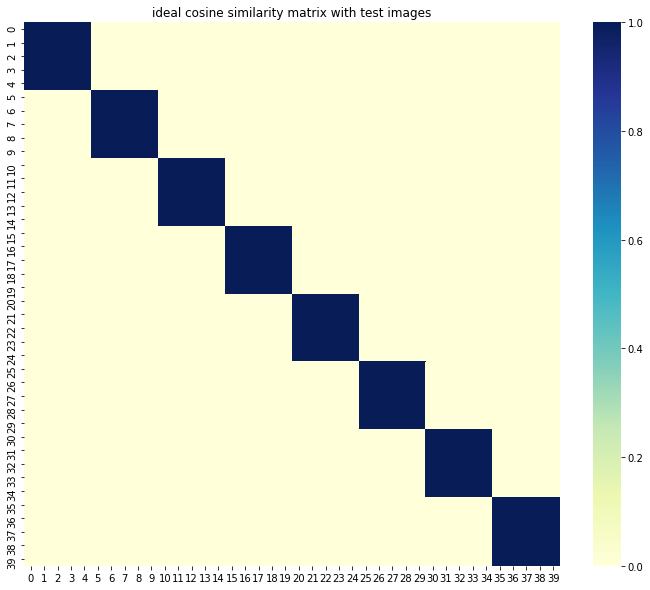

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ideal cosine similarity matrix with test images')
ax = sns.heatmap(np.array(ideal_mat),cmap="YlOrRd")

# Average embedding visualization
---
We obtain the average value of all the embeddings from each of the classes in the training dataset and then calculating cosine similarity between those average embeddings and the embeddings for each individual image in the test dataset

In [ ]:
def getavg(vects):
  return tf.constant(np.average(np.array(vects),axis=0))

y = list(Y)
c = Counter(y)
counts = []
for i in c:
  counts.append(c[i])

In [ ]:
vgg_avgarrays = []
resnet_avgarrays = []
efficientnet_avgarrays = []
e = 0 
for i in counts:
  av1 = getavg(vgg_train_embeddings[e:e+i])
  av2 = getavg(resnet_train_embeddings[e:e+i])
  av3 = getavg(efficientnet_train_embeddings[e:e+i])
  vgg_avgarrays.append(av1)
  resnet_avgarrays.append(av2)
  efficientnet_avgarrays.append(av3)
  e+=i

In [ ]:
vgg_avg_matrix = []
resnet_avg_matrix = []
efficientnet_avg_matrix = []
for i in range(len(vgg_avgarrays)):
  m1 = []
  m2 = []
  m3 = []
  for j in range(len(vgg_test_embeddings)):
    m1.append(cosine_similarity([vgg_avgarrays[i],tf.constant(vgg_test_embeddings[j])]).numpy()[0][0])
    m2.append(cosine_similarity([resnet_avgarrays[i],tf.constant(resnet_test_embeddings[j])]).numpy()[0][0])
    m3.append(cosine_similarity([efficientnet_avgarrays[i],tf.constant(efficientnet_test_embeddings[j])]).numpy()[0][0])
  vgg_avg_matrix.append(m1)
  resnet_avg_matrix.append(m2)
  efficientnet_avg_matrix.append(m3)

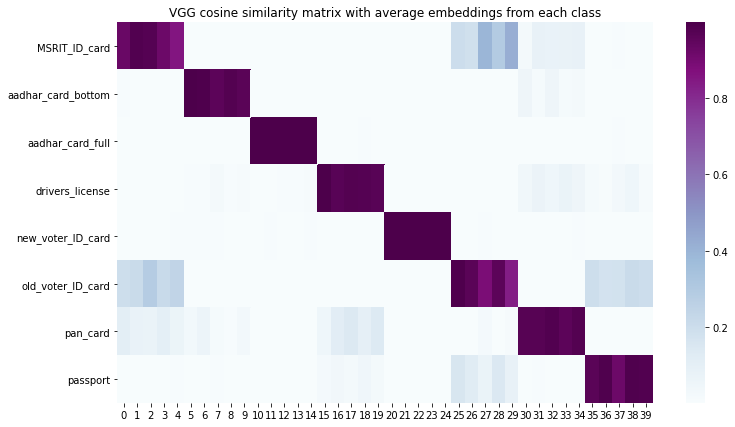

In [ ]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='VGG cosine similarity matrix with average embeddings from each class')
ax = sns.heatmap(np.array(vgg_avg_matrix),cmap="BuPu",yticklabels=class_names_test)

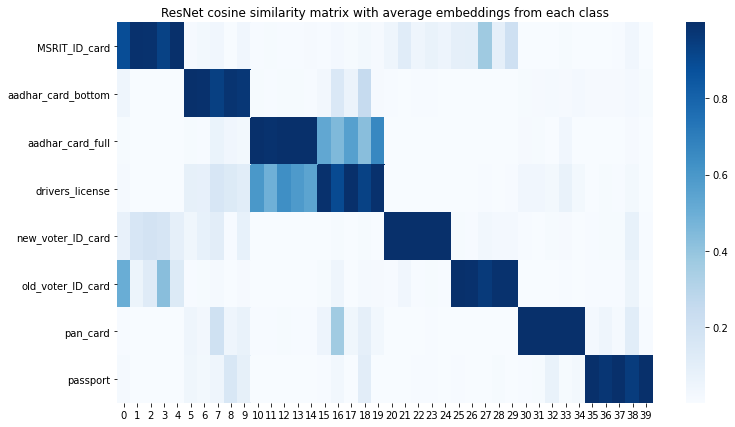

In [ ]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='ResNet cosine similarity matrix with average embeddings from each class')
ax = sns.heatmap(np.array(resnet_avg_matrix),cmap="Blues",yticklabels=class_names_test)

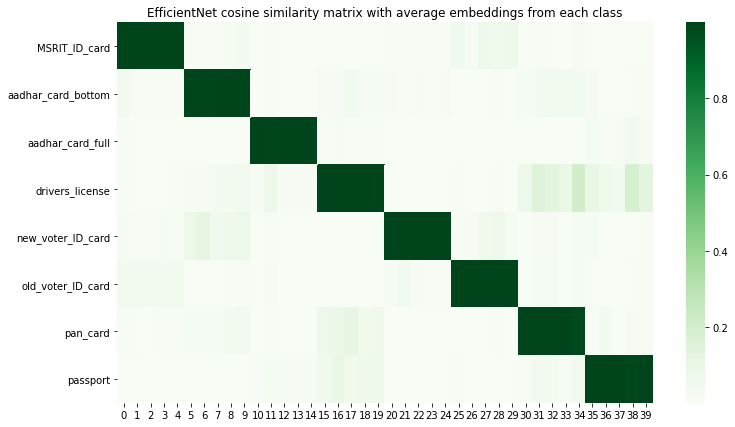

In [ ]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='EfficientNet cosine similarity matrix with average embeddings from each class')
ax = sns.heatmap(np.array(efficientnet_avg_matrix),cmap="Greens",yticklabels=class_names_test)

# Tabulating data to store in database

In [ ]:
table_data = []
for h,i,j,k in zip(Y, vgg_train_embeddings, resnet_train_embeddings, efficientnet_train_embeddings):
  m = [h,i[0], j[0], k[0]]
  table_data.append(m)

m = np.array(table_data,dtype=object)
print("data shape:",m.shape)

data shape: (88, 4)


In [ ]:
old = list(range(len(class_names)))
df = pd.DataFrame(data = m, columns = ['class', 'vgg_embeddings', 'resnet_embeddings', 'efficientnet_embeddings'])
df['class'] = df['class'].replace(old,class_names)
df

,class,vgg_embeddings,resnet_embeddings,efficientnet_embeddings
0,MSRIT_ID_card,"[2.758958e-10, 7.658661e-05, 0.0002347512, 1.5...","[0.0001423835, 0.00018148297, 0.0028549782, 0....","[4.6788573e-05, 0.00011066393, 1.2707215e-05, ..."
1,MSRIT_ID_card,"[3.0180834e-11, 0.00024079987, 4.2194548e-05, ...","[7.200384e-05, 0.00016313288, 0.0016987838, 0....","[5.3821313e-05, 7.7748235e-05, 2.3489163e-05, ..."
2,MSRIT_ID_card,"[9.323e-12, 0.009192235, 0.002774602, 2.849431...","[0.00017646847, 0.000291066, 0.0011027514, 0.0...","[0.00012381535, 4.6885987e-05, 8.078115e-05, 9..."
3,MSRIT_ID_card,"[2.414028e-10, 0.001245118, 0.00030564104, 2.2...","[8.5944244e-05, 0.00023007438, 0.0016700203, 0...","[4.0653656e-05, 7.605452e-05, 2.689651e-05, 0...."
4,MSRIT_ID_card,"[3.308913e-10, 0.017373443, 0.0017042177, 5.10...","[0.000112511414, 0.000208058, 0.0009877491, 0....","[3.7185928e-05, 0.00012097658, 1.6195858e-05, ..."
...,...,...,...,...
83,passport,"[4.2820917e-14, 9.615569e-06, 0.0984584, 5.170...","[0.00012271588, 0.00015835723, 1.0674182e-05, ...","[0.00013309877, 5.11634e-05, 0.00019614563, 4...."
84,passport,"[3.282223e-14, 0.0014178407, 0.17300929, 8.266...","[0.00017196413, 0.00018624139, 1.2124288e-05, ...","[0.00017901091, 4.298883e-05, 0.00025371017, 4..."
85,passport,"[9.101006e-16, 1.3404101e-05, 0.00011410498, 7...","[0.0001934008, 0.00021182757, 8.1964945e-06, 4...","[0.00018691456, 4.2882864e-05, 0.0004386678, 5..."
86,passport,"[1.8271319e-14, 0.0002394911, 0.072365835, 7.5...","[0.000104704304, 0.00024204745, 1.47216615e-05...","[9.420022e-05, 5.546089e-05, 9.123202e-05, 3.4..."


In [ ]:
# df.to_json('embeddings.json',orient='records')

# Saving models

In [ ]:
# vgg_model.save("/content/drive/MyDrive/saved_models/vgg_model_new.h5")
# resnet_model.save("/content/drive/MyDrive/saved_models/resnet_model_new.h5")
# efficientnet_model.save("/content/drive/MyDrive/saved_models/efficientnet_model_new.h5")